In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import torch
from dataset import Asbest_segmentation
from tqdm import tqdm
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from utils import parse_anno_file, create_mask_file, big_image_predict, get_time, true_results
from torch.utils.data import DataLoader

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
class AverageMeter(object):
    def __init__(self):
        self.initialized = False
        self.val = None
        self.avg = None
        self.sum = None
        self.count = None

    def initialize(self, val, weight):
        self.val = val
        self.avg = val
        self.sum = val * weight
        self.count = weight
        self.initialized = True

    def update(self, val, weight=1):
        if not self.initialized:
            self.initialize(val, weight)
        else:
            self.add(val, weight)

    def add(self, val, weight):
        self.val = val
        self.sum += val * weight
        self.count += weight
        self.avg = self.sum / self.count

    def value(self):
        return self.val

    def average(self):
        return self.avg

In [7]:
path_to_data = 'asbestos'
# anno_stones = parse_anno_file(os.path.join(path_to_data, 'images', 'annotation.xml'))
anno_tr_stones = parse_anno_file(os.path.join(path_to_data, 'tr_stones', 'annotation', 'annotation.xml'), os.path.join(path_to_data, 'tr_stones', 'images'))

In [8]:
imp_anno_tr_stones = []
for it in anno_tr_stones:
    name = it['name'].split('/')[-1]
#     if get_time(name).day != 16:
#         continue
    probe = int(name.split('_')[0])
    if probe < 10 or probe > 14:
        continue
    imp_anno_tr_stones.append(it)

In [9]:
device = torch.device("cuda:" + str(torch.cuda.device_count() - 1) if torch.cuda.is_available() else "cpu")

stone_model = smp.Unet(encoder_name='efficientnet-b3', in_channels=1, classes=2, activation='sigmoid').to(device)
asbest_model_1 = smp.Unet(encoder_name='efficientnet-b3', in_channels=1, classes=2, activation='sigmoid').to(device)
# asbest_model_2 = smp.Unet(encoder_name='efficientnet-b3', in_channels=1, classes=2, activation='sigmoid').to(device)

stone_model.load_state_dict(torch.load('stone_asbest_segmentation.pth'))
stone_model.eval();
asbest_model_1.load_state_dict(torch.load('asbest_segmentation_b3_v1.3.pth'))
asbest_model_1.eval();
# asbest_model_2.load_state_dict(torch.load('asbest_segmentation_b3_final.pth'))
# asbest_model_2.eval();

asbestos/tr_stones/images/3_11:37:56_16-03-2020_1.png


/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


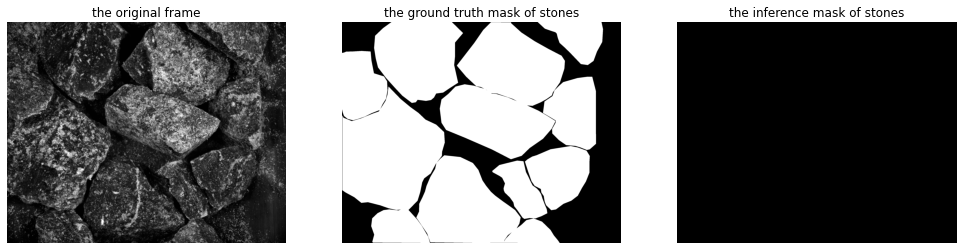

In [11]:
img_size=(1024,1024)
# сrop_size=(1024,1024)
index = 100
print(anno_tr_stones[index]['name'])


img = cv2.imread(anno_tr_stones[index]['name'], cv2.IMREAD_UNCHANGED)
tr_st = create_mask_file(anno_tr_stones[index], 'stone')
img, st, asb = big_image_predict(stone_model, 
                                  img, 
                                  crop_size=(img.shape[0] // 2, img.shape[1] // 2),
                                  inp_size=img_size,
                                  device=device
                                 )
plt.figure(figsize=(17,10), frameon=False)
plt.subplot(131)
plt.imshow(img, cmap=plt.cm.gray)
plt.axis('off')
plt.title('the original frame')
plt.subplot(132)
plt.imshow(tr_st, cmap=plt.cm.gray)
plt.axis('off')
plt.title('the ground truth mask of stones')
plt.subplot(133)
plt.imshow(st > 0.1, cmap=plt.cm.gray)
plt.axis('off')
plt.title('the inference mask of stones')
# plt.subplot(133)
# plt.imshow(asb)
plt.savefig('graphics/stones.png', bbox_inches='tight', pad_inches=0)
# cv2.imwrite('graphics/image_10.png', (255 * img).astype(np.uint8))
# cv2.imwrite('graphics/stone_10.png', (255 * (st > 0.1)).astype(np.uint8))

asbestos/tr_stones/images/11_11:59:20_16-03-2020_1.png


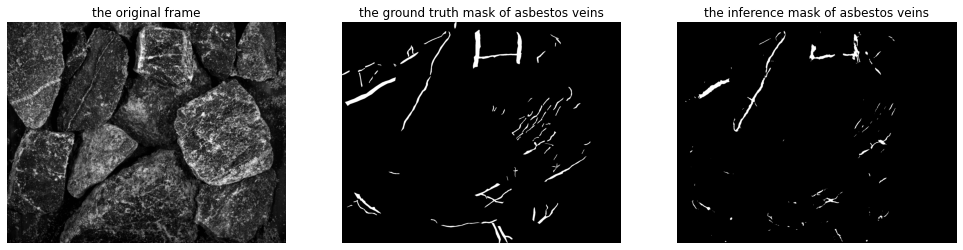

In [14]:
img_size=(1024, 1024)
index = 5
print(anno_tr_stones[index]['name'])


img = cv2.imread(anno_tr_stones[index]['name'], cv2.IMREAD_UNCHANGED)
tr_asb = create_mask_file(anno_tr_stones[index], 'asbest')

img, st, asb = big_image_predict(asbest_model_1, 
                                  img, 
                                  crop_size=img_size,
                                  inp_size=img_size,
                                  device=device
                                 )
plt.figure(figsize=(17,10), frameon=False)
plt.subplot(131)
plt.imshow(img, cmap=plt.cm.gray)
plt.axis('off')
plt.title('the original frame')
plt.subplot(132)
plt.imshow(tr_asb, cmap=plt.cm.gray)
plt.axis('off')
plt.title('the ground truth mask of asbestos veins')
plt.subplot(133)
plt.imshow(asb > 0.9, cmap=plt.cm.gray)
plt.axis('off')
plt.title('the inference mask of asbestos veins')
# plt.subplot(133)
# plt.imshow(asb)
plt.savefig('graphics/asbestos.png', bbox_inches='tight', pad_inches=0)

In [8]:
crop_size = (1024, 1024)
img_size = (512, 512)
model = asbest_model_1

metrics = [
    smp.utils.metrics.IoU(eps=1.),
    smp.utils.metrics.Fscore(eps=1.),
]

model.eval()

tr_stones_train_data = Asbest_segmentation(imp_anno_tr_stones[:10],  
                                            crop_size=crop_size, 
                                            img_size=img_size,
                                            load_in_ram = False,
                                            num_frames=5*10, 
                                            normalize=True
                                           )
tr_stones_train_loader = DataLoader(tr_stones_train_data, batch_size=1, shuffle=False, num_workers=2)

train_average_total_loss = AverageMeter()
train_average_asb_iou = AverageMeter()
train_average_asb_dice = AverageMeter()

for data in tr_stones_train_loader:

    torch.cuda.empty_cache()
    inputs, st_masks, asb_masks = data

    inputs=inputs.to(device).float()
    st_masks=st_masks.to(device).float()
    asb_masks=asb_masks.to(device).float()

    outputs = model(inputs)

#     loss = 0.5 * bce(outputs[:,1:2,:,:], asb_masks) + 0.5 * dice(outputs[:,1:2,:,:], asb_masks) + 0.0 * dice(outputs[:,1:2,:,:], asb_masks)
    asb_iou = metrics[0](outputs[:,1:2,:,:], asb_masks)
    asb_dice = metrics[1](outputs[:,1:2,:,:], asb_masks)

#     train_average_total_loss.update(loss.data.item())
    train_average_asb_iou.update(asb_iou.data.item())
    train_average_asb_dice.update(asb_dice.data.item())
    
print(train_average_asb_iou.average(), train_average_asb_dice.average())

tr_stones_valid_data = Asbest_segmentation(imp_anno_tr_stones[10:13],  
                                            crop_size=crop_size, 
                                            img_size=img_size,
                                            load_in_ram = False,
                                            num_frames=3*5, 
                                            normalize=True
                                           )
tr_stones_valid_loader = DataLoader(tr_stones_valid_data, batch_size=1, shuffle=False, num_workers=2)

valid_average_total_loss = AverageMeter()
valid_average_asb_iou = AverageMeter()
valid_average_asb_dice = AverageMeter()

for data in tr_stones_valid_loader:

    torch.cuda.empty_cache()
    inputs, st_masks, asb_masks = data

    inputs=inputs.to(device).float()
    st_masks=st_masks.to(device).float()
    asb_masks=asb_masks.to(device).float()

    outputs = model(inputs)

#     loss = 0.5 * bce(outputs[:,1:2,:,:], asb_masks) + 0.5 * dice(outputs[:,1:2,:,:], asb_masks) + 0.0 * dice(outputs[:,1:2,:,:], asb_masks)
    asb_iou = metrics[0](outputs[:,1:2,:,:], asb_masks)
    asb_dice = metrics[1](outputs[:,1:2,:,:], asb_masks)

#     valid_average_total_loss.update(loss.data.item())
    valid_average_asb_iou.update(asb_iou.data.item())
    valid_average_asb_dice.update(asb_dice.data.item())
    
print(valid_average_asb_iou.average(), valid_average_asb_dice.average())

tr_stones_test_data = Asbest_segmentation(imp_anno_tr_stones[13:],  
                                            crop_size=crop_size, 
                                            img_size=img_size,
                                            load_in_ram = False,
                                            num_frames=2*5, 
                                            normalize=True
                                           )
tr_stones_test_loader = DataLoader(tr_stones_test_data, batch_size=1, shuffle=False, num_workers=2)

test_average_total_loss = AverageMeter()
test_average_asb_iou = AverageMeter()
test_average_asb_dice = AverageMeter()

for data in tr_stones_test_loader:

    torch.cuda.empty_cache()
    inputs, st_masks, asb_masks = data

    inputs=inputs.to(device).float()
    st_masks=st_masks.to(device).float()
    asb_masks=asb_masks.to(device).float()

    outputs = model(inputs)

#     loss = 0.5 * bce(outputs[:,1:2,:,:], asb_masks) + 0.5 * dice(outputs[:,1:2,:,:], asb_masks) + 0.0 * dice(outputs[:,1:2,:,:], asb_masks)
    asb_iou = metrics[0](outputs[:,1:2,:,:], asb_masks)
    asb_dice = metrics[1](outputs[:,1:2,:,:], asb_masks)

#     test_average_total_loss.update(loss.data.item())
    test_average_asb_iou.update(asb_iou.data.item())
    test_average_asb_dice.update(asb_dice.data.item())
    
print(test_average_asb_iou.average(), test_average_asb_dice.average())

0.654307720977813 0.7528873953409493
0.5985873659451802 0.7381512999534607
0.4670955688809045 0.6047894717310556


In [5]:
img_size=(448, 448)

img = cv2.imread('asbest/tr_stones/10_11:56:13_16-03-2020_1.png', cv2.IMREAD_UNCHANGED)
img, st, asb = big_image_predict(asbest_model_2, 
                                  img, 
                                  crop_size=(img.shape[0] // 2, img.shape[1] // 2),
                                  inp_size=img_size,
                                  device=device
                                 )
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(asb > 0.5)
# plt.subplot(133)
# plt.imshow(asb)

# cv2.imwrite('graphics/image_5.png', (255 * img).astype(np.uint8))
cv2.imwrite('graphics/asbest_10_v2.png', (255 * (asb > 0.5)).astype(np.uint8))

NameError: name 'asbest_model_2' is not defined

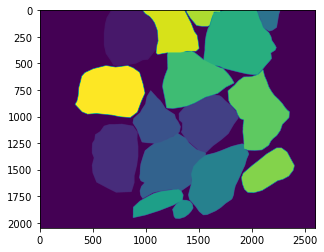

In [9]:
anno_file = 'asbest/tr_stones/annotation.xml'
anno = parse_anno_file(anno_file)
msk = create_mask_file(anno[3], 'stone', binary=False)
plt.imshow(msk)

True

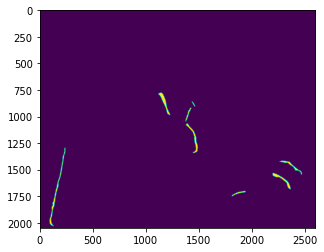

In [10]:
for it in anno:
    if it['name'] == 'asbest/tr_stones/10_11:56:13_16-03-2020_1.png':
        msk = create_mask_file(it, 'asbest')
        plt.imshow(msk)
        break
cv2.imwrite('graphics/asbest_10_manual.png', (255 * (msk > 0.5)).astype(np.uint8))

In [16]:
manual_results = {'probes' : [], 'day' : [], 'preds' : [], 'trues' : [], 'asbest' : [], 'stones' : []}
net_results = {'probes' : [], 'day' : [], 'preds' : [], 'trues' : [], 'asbest' : [], 'stones' : []}


for it in anno:
    name = it['name'].split('/')[-1]
    if get_time(name).day != 16:
        continue
    probe = int(name.split('_')[0])
    if probe < 10 or probe > 14:
        continue
    st_mask = create_mask_file(it, 'stone', binary=True)
    asb_mask = create_mask_file(it, 'asbest', binary=True)
    manual_results['probes'].append(probe)
    manual_results['preds'].append(100 * np.sum(asb_mask) / np.sum(st_mask))
    manual_results['asbest'].append(np.sum(asb_mask))
    manual_results['stones'].append(np.sum(st_mask))
    manual_results['trues'].append(true_results[16][probe])
    manual_results['day'].append(get_time(name).day)

for it in tqdm(anno, total=len(anno)):
    name = it['name'].split('/')[-1]
#     if get_time(name).day != 16:
#         continue
    probe = int(name.split('_')[0])
#     if probe < 10 or probe > 14:
#         continue
#                     probe = int(name.split('_')[0])
    img = cv2.imread(it['name'], cv2.IMREAD_UNCHANGED)
    _, _, asb_mask = big_image_predict(asbest_model_1, 
                                      img, 
                                      crop_size=(img.shape[0] // 2, img.shape[1] // 2),
                                      inp_size=(512,512),
                                      device=device
                                     )
    _, st_mask, _ = big_image_predict(stone_model, 
                                  img, 
                                  crop_size=(img.shape[0] // 2, img.shape[1] // 2),
                                  inp_size=(1024,1024),
                                  device=device
                                 )
#     st_mask = create_mask_file(it, 'stone', binary=True)
    st_mask = st_mask > 0.1
    asb_mask = asb_mask > 0.5
#     asb_mask = create_mask_file(it, 'asbest')
    net_results['probes'].append(probe)
    net_results['preds'].append(100 * np.sum(asb_mask) / np.sum(st_mask))
    net_results['asbest'].append(np.sum(asb_mask))
    net_results['stones'].append(np.sum(st_mask))
    net_results['trues'].append(true_results[16][probe])
    net_results['day'].append(get_time(name).day)

100%|██████████| 134/134 [04:05<00:00,  1.83s/it]


In [25]:
index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

Text(0, 0.5, 'Лабораторное содержание асбеста, %')

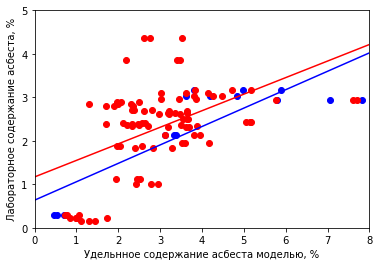

In [29]:
p_manual = np.polyfit(manual_results['preds'], manual_results['trues'], 1)
reg_manual = np.polyval(p_manual, [0, 10])

index = np.array(net_results['day']) == 16
p_net = np.polyfit(np.array(net_results['preds'])[index], np.array(net_results['trues'])[index], 1)
reg_net = np.polyval(p_net, [0, 10])


plt.scatter(manual_results['preds'], manual_results['trues'], c='b')
plt.plot([0, 10], reg_manual, 'b')

plt.scatter(np.array(net_results['preds'])[index], np.array(net_results['trues'])[index], c='r')
plt.plot([0, 10], reg_net, 'r')
plt.xlim(0, 8)
plt.ylim(0, 5)
plt.xlabel('Удельнное содержание асбеста моделью, %')
plt.ylabel('Лабораторное содержание асбеста, %')

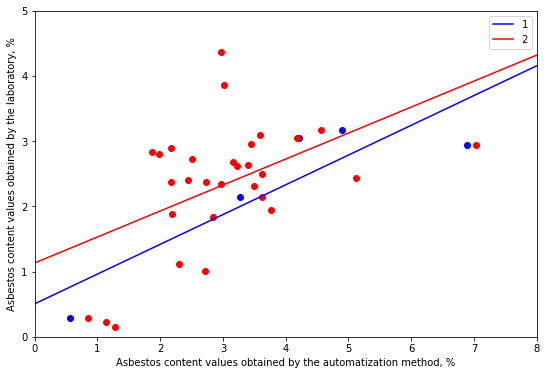

In [32]:
mean_manual_results = {'probes' : [], 'day' : [], 'preds' : [], 'trues' : []}
mean_net_results = {'probes' : [], 'day' : [], 'preds' : [], 'trues' : []}

for day in [16]:
    for prob in range(1,31):
        index_day = np.array(manual_results['day']) == day
        index_prob = np.array(manual_results['probes'])[index_day] == prob
        if any(index_prob):
            mean_manual_results['probes'].append(prob)
            mean_manual_results['day'].append(day)
            mean_manual_results['preds'].append(np.mean(np.array(manual_results['preds'])[index_day][index_prob]))
            mean_manual_results['trues'].append(np.mean(np.array(manual_results['trues'])[index_day][index_prob]))

        index_day = np.array(net_results['day']) == day
        index_prob = np.array(net_results['probes'])[index_day] == prob
        if any(index_prob):
            mean_net_results['probes'].append(prob)
            mean_net_results['day'].append(day)
            mean_net_results['preds'].append(np.mean(np.array(net_results['preds'])[index_day][index_prob]))
            mean_net_results['trues'].append(np.mean(np.array(net_results['trues'])[index_day][index_prob]))

        
p_manual = np.polyfit(mean_manual_results['preds'], mean_manual_results['trues'], 1)
reg_manual = np.polyval(p_manual, [0, 10])

p_net = np.polyfit(mean_net_results['preds'], mean_net_results['trues'], 1)
reg_net = np.polyval(p_net, [0, 10])


plt.figure(figsize=(9,6))
plt.scatter(mean_manual_results['preds'], mean_manual_results['trues'], c='b')
sigma_manual = np.sqrt(np.sum((np.array(mean_manual_results['trues']) - np.polyval(p_manual, mean_manual_results['preds'])) ** 2) / (len(mean_manual_results['trues']) - 1))
plt.plot([0, 10], reg_manual, 'b', label= '1')#label='СКО = ' + '{:.2f}'.format(sigma_manual))

sigma_net = np.sqrt(np.sum((np.array(mean_net_results['trues']) - np.polyval(p_net, mean_net_results['preds'])) ** 2) / (len(mean_net_results['trues']) - 1))
plt.scatter(mean_net_results['preds'], mean_net_results['trues'], c='r')
plt.plot([0, 10], reg_net, 'r', label= '2')#'СКО = ' + '{:.2f}'.format(sigma_net))

plt.legend()
plt.xlim(0, 8)
plt.ylim(0, 5)
plt.xlabel('Asbestos content values obtained by the automatization method, %')
plt.ylabel('Asbestos content values obtained by the laboratory, %')
plt.savefig('graphics/result_asbestos.png', bbox_inches='tight', dpi=300)

In [35]:
print(p_manual)
print(p_net)
print(p_net-p_manual)

[0.45630692 0.50455357]
[0.39840004 1.13135771]
[-0.05790688  0.62680414]


In [20]:
sigma_net

0.8315475079699358

In [46]:
img_size=(512, 512)
files = []
num = []
probes = []
trues = []
predicts = []
positions = []
for i, it in tqdm(enumerate(anno), total=len(anno)):
    if get_time(it['name'].split('/')[-1]).day != 16:
        continue
    num.append(i)
    files.append(it['name'])
    probes.append(int(it['name'].split('/')[-1].split('_')[0]))
    trues.append(true_results[16][int(it['name'].split('/')[-1].split('_')[0])])
    img = cv2.imread(it['name'], cv2.IMREAD_GRAYSCALE)
#     msk = create_mask_file(it, 'stone', binary=False)
    _, st, _ = big_image_predict(stone_model, 
                                  img, 
                                  crop_size=(img.shape[0] // 2, img.shape[1] // 2),
                                  inp_size=img_size,
                                  device=device
                                 )
    _, _, asb = big_image_predict(asbest_model_1, 
                                  img, 
                                  crop_size=(img.shape[0] // 2, img.shape[1] // 2),
                                  inp_size=img_size,
                                  device=device
                                 )
    asb = asb > 0.5
    asb_in_stn_conc = []
    x_pos = []
    y_pos = []
    for st in np.unique(msk)[1:]:
        st_msk = msk == st
        if np.sum(st_msk) < 100000:
            asb_in_stn_conc.append(0)
        else:
            asb_in_stn_conc.append(100 * np.sum(st_msk * asb) / np.sum(st_msk))
        y, x = np.where(st_msk == True)
        x_pos.append(np.mean(x))
        y_pos.append(np.mean(y))
    positions.append([x_pos, y_pos])
    predicts.append(asb_in_stn_conc)
#     asbest_conc.append(np.sort(asb_in_stn_conc))


100%|██████████| 134/134 [01:38<00:00,  1.36it/s]


asbest/tr_stones/6_11:46:20_16-03-2020_1.png


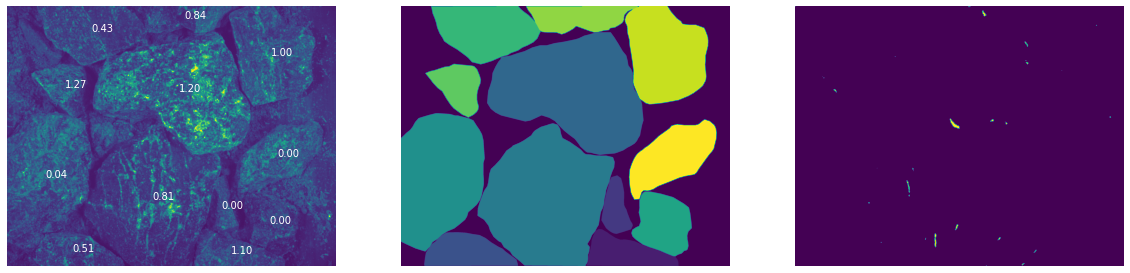

In [52]:
it = 80
img = cv2.imread(files[it], cv2.IMREAD_GRAYSCALE)
fig = plt.figure()
fig.set_size_inches(20,15)
plt.subplot(131)
plt.imshow(img);
plt.axis('off');
for i in range(len(predicts[it])):
    plt.text(positions[it][0][i],positions[it][1][i], '{0:.2f}'.format(predicts[it][i]), color='w');
    
plt.subplot(132)
msk = create_mask_file(anno[num[it]], 'stone', binary=False)
plt.imshow(msk);
plt.axis('off');

plt.subplot(133)
_, _, asb = big_image_predict(asbest_model, 
                              img, 
                              crop_size=(img.shape[0] // 2, img.shape[1] // 2),
                              inp_size=img_size,
                              device=device
                             )
plt.imshow(asb > 0.95);
plt.axis('off');
print(files[it])
plt.savefig('graphics/images_' + str(probes[it]) + '.png', dpi=100)

In [67]:
data = {}
data['проба'] = probes
data['лаб'] = trues
data['1'] = [np.mean(np.sort(pred)[-1:]) for pred in predicts]
data['2'] = [np.mean(np.sort(pred)[-2:]) for pred in predicts]
data['3'] = [np.mean(np.sort(pred)[-3:]) for pred in predicts]
data['4'] = [np.mean(np.sort(pred)[-4:]) for pred in predicts]
data['5'] = [np.mean(np.sort(pred)[-5:]) for pred in predicts]

In [68]:
df = pd.DataFrame(data)
gb = df.groupby('проба')
gb = gb.agg({'лаб' : np.mean,
        '1' : [np.min, np.mean, np.max],
        '2' : [np.min, np.mean, np.max],
        '3' : [np.min, np.mean, np.max],
        '4' : [np.min, np.mean, np.max],
        '5' : [np.min, np.mean, np.max],
       })
gb

лаб         1                               2                      \
       mean      amin       mean       amax      amin      mean      amax   
проба                                                                       
1      1.94  3.056860   6.359873   9.628440  1.990533  4.835133  7.202708   
2      1.89  2.064109   4.829722   9.523245  1.882003  4.405753  8.527520   
3      2.89  2.452407   4.202935   6.026847  2.405342  3.443031  4.991197   
4      2.62  6.101912   6.862415   7.541187  5.629495  6.011054  6.543643   
5      1.12  3.328945   6.110475  10.272598  2.409838  4.427455  6.913079   
6      3.86  1.272541   2.324987   3.257909  1.237284  2.140563  2.800502   
7      2.72  3.234842   4.281088   5.077666  2.972861  3.558622  4.289773   
8      2.84  2.761791   6.211302   9.383532  2.615506  4.973833  7.094071   
9      2.37  1.904173   4.631342   6.586144  1.901337  3.993602  5.293099   
10     0.29  2.679429   3.326312   4.378921  2.015382  2.883924  3.923794   
11     2.14  2.713433   9.680851  14.484192  2.679325  7.044896  9.743750   
12     3.17  3.442260   5.315517   7.119445  3.372745  4.430115  5.742291   
13     3.04  5.245235   6.203464   6.945181  4.313553  5.401709  6.854118   
14     2.94  4.127871   5.478421   8.111772  3.523856  4.606079  6.470066   
15     2.40  2.824924   3.673350   4.165538  2.755229  3.290621  4.028324   
16     2.35  2.719549   4.064171   5.600090  2.597250  3.590715  4.523319   
17     3.09  9.768404  12.131083  14.858259  7.832728  8.721945  9.710474   
18     2.80  1.724315   2.580007   3.274507  1.187791  1.958240  2.450120   
19     2.38  7.734132   9.314675  11.126180  6.428964  6.772000  7.140409   
20     0.22  0.492530   1.549509   2.226924  0.444991  1.140200  1.687330   
21     1.01  2.352969   2.941699   3.568728  2.343709  2.684373  2.956580   
22     4.36  5.134722   7.342434  10.177841  4.300587  4.922559  6.161431   
23     2.64  4.879873   5.152103   5.664681  3.623111  3.979891  4.335095   
24     1.83  2.616561   4.229652   6.275533  2.433486  3.690744  5.044182   
25     2.50  4.009397   6.004236   7.678000  3.673375  4.763650  6.253717   
26     2.44  5.418197   7.096709   7.997527  4.959288  6.204439  7.095698   
27     2.31  4.494901   5.116630   6.004651  4.192803  4.420761  4.663712   
28     2.68  3.921743   4.724836   5.357902  2.876124  3.899856  4.814290   
29     2.96  3.006084   6.280135   9.519999  2.921393  4.970179  6.301723   
30     0.15  2.400075   2.687329   2.882706  1.739774  1.808773  1.929033   

              3                             4                             5  \
           amin      mean      amax      amin      mean      amax      amin   
проба                                                                         
1      1.632274  3.979685  6.275416  1.417982  3.481086  5.707255  1.286362   
2      1.818925  3.791504  7.229725  1.622670  3.167519  5.868576  1.481416   
3      2.146018  2.914542  4.216184  1.923604  2.585815  3.801153  1.700427   
4      5.090959  5.632076  6.202430  4.757817  5.274892  5.909927  4.544294   
5      1.893144  3.654060  5.782040  1.609127  3.148584  4.995459  1.428755   
6      1.190528  1.991479  2.457623  1.143746  1.834564  2.294748  1.083380   
7      2.788929  3.270547  4.179947  2.456413  2.999901  3.783454  2.179247   
8      2.513615  4.131806  5.707525  2.251800  3.584511  4.983914  2.049694   
9      1.723412  3.421343  4.792592  1.531858  3.012218  4.307930  1.351839   
10     1.781507  2.549797  3.307366  1.553123  2.243748  2.833967  1.401755   
11     2.319645  5.740146  7.798205  2.051451  4.961718  6.571008  1.836768   
12     3.295861  4.040855  5.139222  2.728597  3.473920  4.376941  2.265755   
13     3.717340  4.628583  5.619380  3.389275  4.108087  4.975948  3.071134   
14     3.225604  3.960045  5.391294  2.879731  3.458822  4.455738  2.560933   
15     2.314123  2.984492  3.874322  2.093394  2.782310  3.795789  1.883890   
16     2.513685  3.312475  4.083743  2.45440

In [69]:
gb.to_csv('graphics/table.csv')

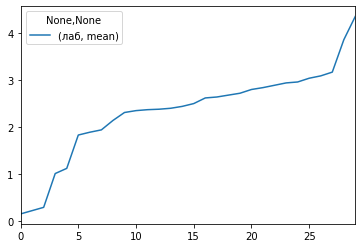

In [76]:
a = gb.sort_values(('лаб', 'mean')).reset_index()
a.plot(y=('лаб', 'mean'))
# plt.savefig('graphics/lab_conc_asbest.png')

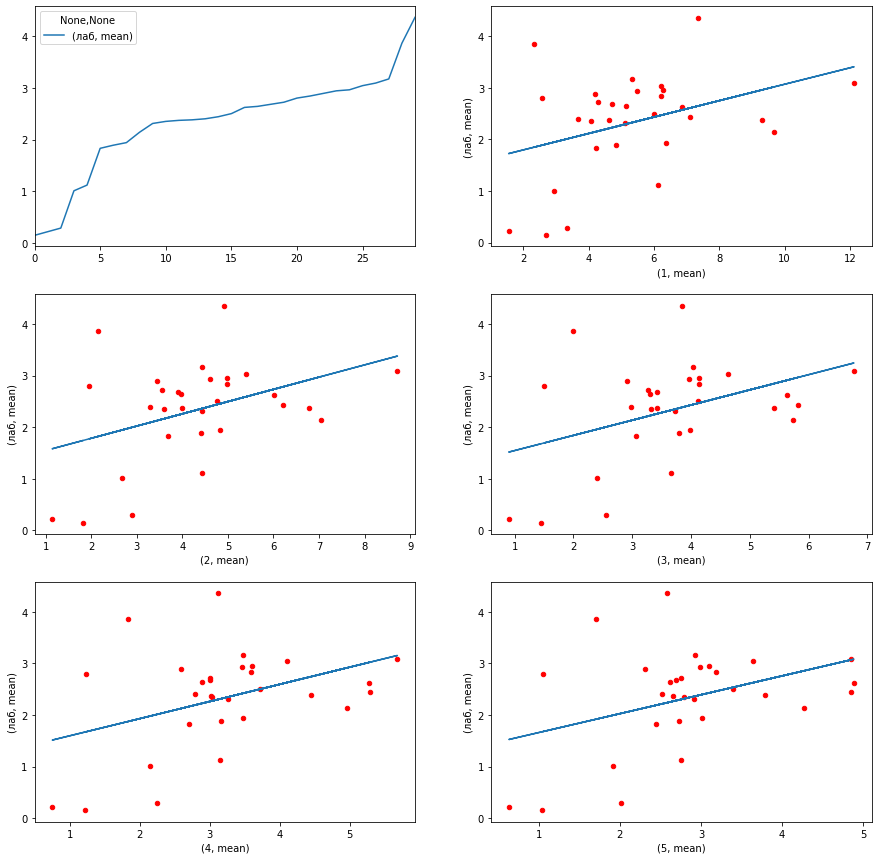

In [77]:
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(15,15)
a.plot(y=('лаб', 'mean'), ax=axes[0,0])
# a.plot(y=[('1 камень', 'amin'), ('1 камень', 'mean'), ('1 камень', 'amax')], ax=axes[0,1])
# a.plot(y=[('2 камня', 'amin'), ('2 камня', 'mean'), ('2 камня', 'amax')], ax=axes[1,0])
# a.plot(y=[('3 камня', 'amin'), ('3 камня', 'mean'), ('3 камня', 'amax')], ax=axes[1,1])
# a.plot(y=[('4 камня', 'amin'), ('4 камня', 'mean'), ('4 камня', 'amax')], ax=axes[2,0])
# a.plot(y=[('5 камней', 'amin'), ('5 камней', 'mean'), ('5 камней', 'amax')], ax=axes[2,1])
a.plot.scatter(x=('1', 'mean'), y=('лаб', 'mean'), ax=axes[0,1], c='r')
axes[0,1].plot(a['1']['mean'], np.polyval(np.polyfit(a['1']['mean'], a['лаб']['mean'], deg=1), a['1']['mean']))
               
a.plot.scatter(x=('2', 'mean'), y=('лаб', 'mean'), ax=axes[1,0], c='r')
axes[1,0].plot(a['2']['mean'], np.polyval(np.polyfit(a['2']['mean'], a['лаб']['mean'], deg=1), a['2']['mean']))

a.plot.scatter(x=('3', 'mean'), y=('лаб', 'mean'), ax=axes[1,1], c='r')
axes[1,1].plot(a['3']['mean'], np.polyval(np.polyfit(a['3']['mean'], a['лаб']['mean'], deg=1), a['3']['mean']))
               
a.plot.scatter(x=('4', 'mean'), y=('лаб', 'mean'), ax=axes[2,0], c='r')
axes[2,0].plot(a['4']['mean'], np.polyval(np.polyfit(a['4']['mean'], a['лаб']['mean'], deg=1), a['4']['mean']))
               
a.plot.scatter(x=('5', 'mean'), y=('лаб', 'mean'), ax=axes[2,1], c='r')
axes[2,1].plot(a['5']['mean'], np.polyval(np.polyfit(a['5']['mean'], a['лаб']['mean'], deg=1), a['5']['mean']))
# a.plot(y=[('3', 'mean')], ax=axes[1,1])
# axes[1,1].plot(np.arange(len(a['3']['mean'])), 
#                np.polyval(np.polyfit(np.arange(len(a['3']['mean'])), a['3']['mean'], deg=1), np.arange(len(a['3']['mean']))))
# a.plot(y=[('4', 'mean')], ax=axes[2,0])
# axes[2,0].plot(np.arange(len(a['4']['mean'])), 
#                np.polyval(np.polyfit(np.arange(len(a['4']['mean'])), a['4']['mean'], deg=1), np.arange(len(a['4']['mean']))))
# a.plot(y=[('5', 'mean')], ax=axes[2,1])
# axes[2,1].plot(np.arange(len(a['5']['mean'])), 
#                np.polyval(np.polyfit(np.arange(len(a['5']['mean'])), a['5']['mean'], deg=1), np.arange(len(a['5']['mean']))))
plt.savefig('graphics/conc_asbest.png')

/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


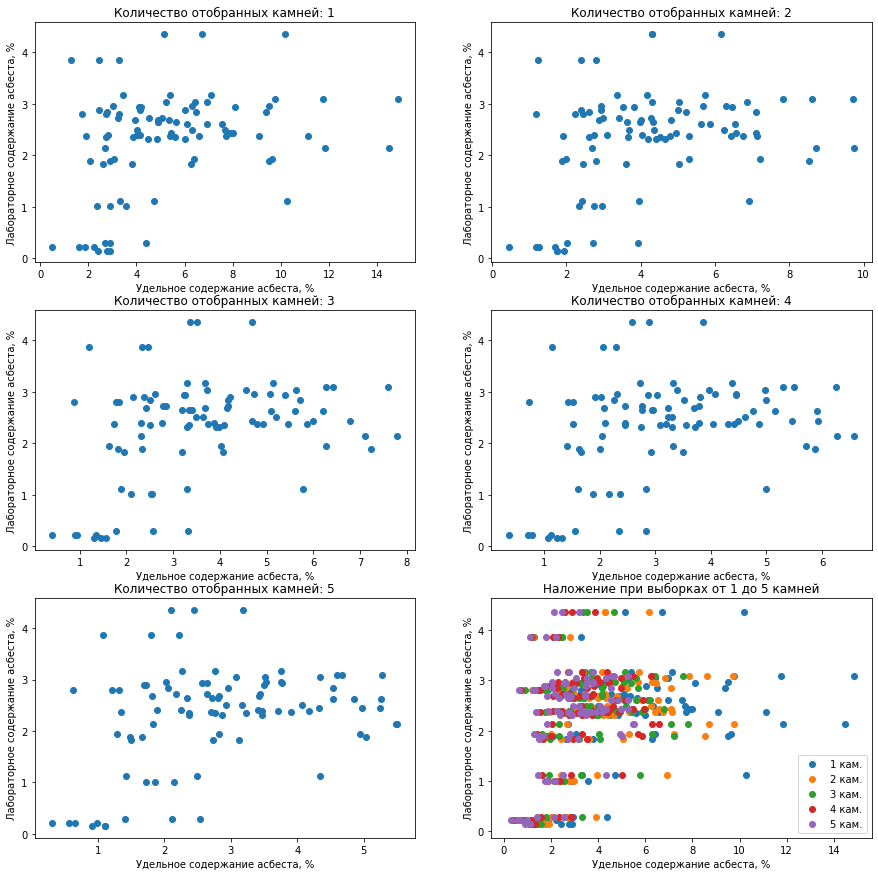

In [79]:
plt.figure(figsize=(15,15))
for num_stones in range(1, 6):
    plt.subplot(3,2, num_stones)
#     data['probe'].append()
    plt.title('Количество отобранных камней: ' + str(num_stones))
    plt.scatter([np.mean(np.sort(pred)[-num_stones:]) for pred in predicts], trues, label=str(num_stones) + ' кам.')
    plt.ylabel('Лабораторное содержание асбеста, %')
    plt.xlabel('Удельное содержание асбеста, %')
#     plt.legend()
    plt.subplot(326)
    plt.scatter([np.mean(np.sort(pred)[-num_stones:]) for pred in predicts], trues, label=str(num_stones) + ' кам.')
    
# plt.xlim((0,15))
    plt.title('Наложение при выборках от 1 до 5 камней')
    plt.ylabel('Лабораторное содержание асбеста, %')
    plt.xlabel('Удельное содержание асбеста, %')
    plt.legend()
plt.savefig('graphics/points_' + str('all') + '.png', dpi = 100)

## По всем камням

In [10]:
device = torch.device("cuda:" + str(torch.cuda.device_count() - 1) if torch.cuda.is_available() else "cpu")

asbest_model_1 = smp.Unet(encoder_name='efficientnet-b3', in_channels=1, classes=2, activation='sigmoid').to(device)
asbest_model_2 = smp.Unet(encoder_name='efficientnet-b3', in_channels=1, classes=2, activation='sigmoid').to(device)

asbest_model_1.load_state_dict(torch.load('asbest_segmentation.pth'))
asbest_model_1.eval();
asbest_model_2.load_state_dict(torch.load('asbest_segmentation_b3_v1.1.pth'))
asbest_model_2.eval();

In [28]:
anno_file = 'asbest/tr_stones/annotation.xml'
anno = parse_anno_file(anno_file)
img_size=(448, 448)
files = []
num = []
probes = []
trues = []
predicts_1 = []
predicts_2 = []
positions = []
for i, it in tqdm(enumerate(anno), total=len(anno)):
    if get_time(it['name'].split('/')[-1]).day != 16:
        continue
    num.append(i)
    files.append(it['name'])
    probes.append(int(it['name'].split('/')[-1].split('_')[0]))
    trues.append(true_results[16][int(it['name'].split('/')[-1].split('_')[0])])
    img = cv2.imread(it['name'], cv2.IMREAD_GRAYSCALE)
    st_msk = create_mask_file(it, 'stone', binary=True)
    _, _, asb_1 = big_image_predict(asbest_model_1, 
                                  img, 
                                  crop_size=(img.shape[0] // 2, img.shape[1] // 2),
                                  inp_size=img_size,
                                  device=device
                                 )
    _, _, asb_2 = big_image_predict(asbest_model_2, 
                                  img, 
                                  crop_size=(img.shape[0] // 2, img.shape[1] // 2),
                                  inp_size=img_size,
                                  device=device
                                 )
    asb_1 = asb_1 > 0.5
    asb_2 = asb_2 > 0.5
    predicts_1.append(100 * np.sum(st_msk * asb_1) / np.sum(st_msk))
    predicts_2.append(100 * np.sum(st_msk * asb_2) / np.sum(st_msk))

100%|██████████| 134/134 [01:59<00:00,  1.12it/s]


In [29]:
manual_results = {'probes' : [], 'preds' : [], 'trues' : [], 'asbest' : [], 'stones' : []}
net_results_1 = {'probes' : [], 'preds' : [], 'trues' : [], 'asbest' : [], 'stones' : []}
net_results_2 = {'probes' : [], 'preds' : [], 'trues' : [], 'asbest' : [], 'stones' : []}

for it in anno:
    name = it['name'].split('/')[-1]
    if get_time(name).day != 16:
        continue
    probe = int(name.split('_')[0])
    if probe < 10 or probe > 14:
        continue
    st_mask = create_mask_file(it, 'stone', binary=True)
    asb_mask = create_mask_file(it, 'asbest', binary=True)
    manual_results['probes'].append(probe)
    manual_results['preds'].append(100 * np.sum(asb_mask) / np.sum(st_mask))
    manual_results['asbest'].append(np.sum(asb_mask))
    manual_results['stones'].append(np.sum(st_mask))
    manual_results['trues'].append(true_results[16][probe])

for it in tqdm(anno, total=len(anno)):
    name = it['name'].split('/')[-1]
    if get_time(name).day != 16:
        continue
    probe = int(name.split('_')[0])
#     if probe < 10 or probe > 14:
#         continue
#                     probe = int(name.split('_')[0])
    img = cv2.imread(it['name'], cv2.IMREAD_UNCHANGED)
    _, _, asb_mask = big_image_predict(asbest_model_1, 
                                      img, 
                                      crop_size=(img.shape[0] // 2, img.shape[1] // 2),
                                      inp_size=img_size,
                                      device=device
                                     )
    st_mask = create_mask_file(it, 'stone', binary=True)
    asb_mask = asb_mask > 0.5
#     asb_mask = create_mask_file(it, 'asbest')
    net_results_1['probes'].append(probe)
    net_results_1['preds'].append(100 * np.sum(asb_mask) / np.sum(st_mask))
    net_results_1['asbest'].append(np.sum(asb_mask))
    net_results_1['stones'].append(np.sum(st_mask))
    net_results_1['trues'].append(true_results[16][probe])
    
    _, _, asb_mask = big_image_predict(asbest_model_2, 
                                      img, 
                                      crop_size=(img.shape[0] // 2, img.shape[1] // 2),
                                      inp_size=img_size,
                                      device=device
                                     )
    
    asb_mask = asb_mask > 0.5
    net_results_2['probes'].append(probe)
    net_results_2['preds'].append(100 * np.sum(asb_mask) / np.sum(st_mask))
    net_results_2['asbest'].append(np.sum(asb_mask))
    net_results_2['stones'].append(np.sum(st_mask))
    net_results_2['trues'].append(true_results[16][probe])

100%|██████████| 134/134 [02:00<00:00,  1.11it/s]


Text(0, 0.5, 'Лабораторное содержание асбеста, %')

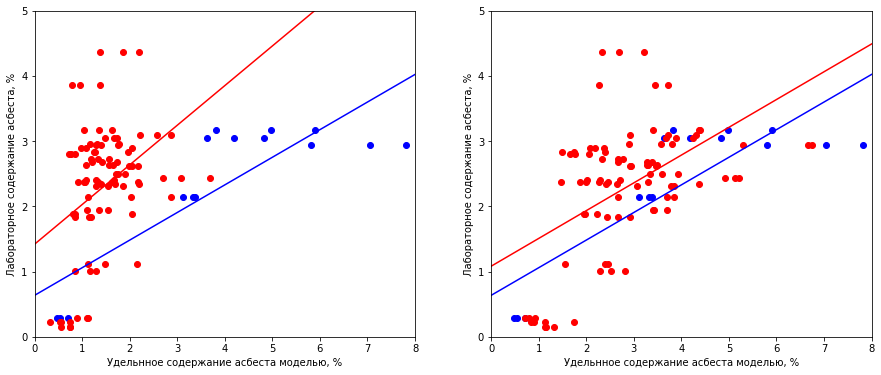

In [32]:
p_manual = np.polyfit(manual_results['preds'], manual_results['trues'], 1)
reg_manual = np.polyval(p_manual, [0, 10])

p_net_1 = np.polyfit(net_results_1['preds'], net_results_1['trues'], 1)
reg_net_1 = np.polyval(p_net_1, [0, 10])

p_net_2 = np.polyfit(net_results_2['preds'], net_results_2['trues'], 1)
reg_net_2 = np.polyval(p_net_2, [0, 10])

plt.figure(figsize=(15,6))
plt.subplot(121)
plt.scatter(manual_results['preds'], manual_results['trues'], c='b')
plt.plot([0, 10], reg_manual, 'b')

plt.scatter(net_results_1['preds'], net_results_1['trues'], c='r')
plt.plot([0, 10], reg_net_1, 'r')
plt.xlim(0, 8)
plt.ylim(0, 5)
plt.xlabel('Удельнное содержание асбеста моделью, %')
plt.ylabel('Лабораторное содержание асбеста, %')

plt.subplot(122)
plt.scatter(manual_results['preds'], manual_results['trues'], c='b')
plt.plot([0, 10], reg_manual, 'b')

plt.scatter(net_results_2['preds'], net_results_2['trues'], c='r')
plt.plot([0, 10], reg_net_2, 'r')
plt.xlim(0, 8)
plt.ylim(0, 5)
plt.xlabel('Удельнное содержание асбеста моделью, %')
plt.ylabel('Лабораторное содержание асбеста, %')

Text(0, 0.5, 'Лабораторное содержание асбеста, %')

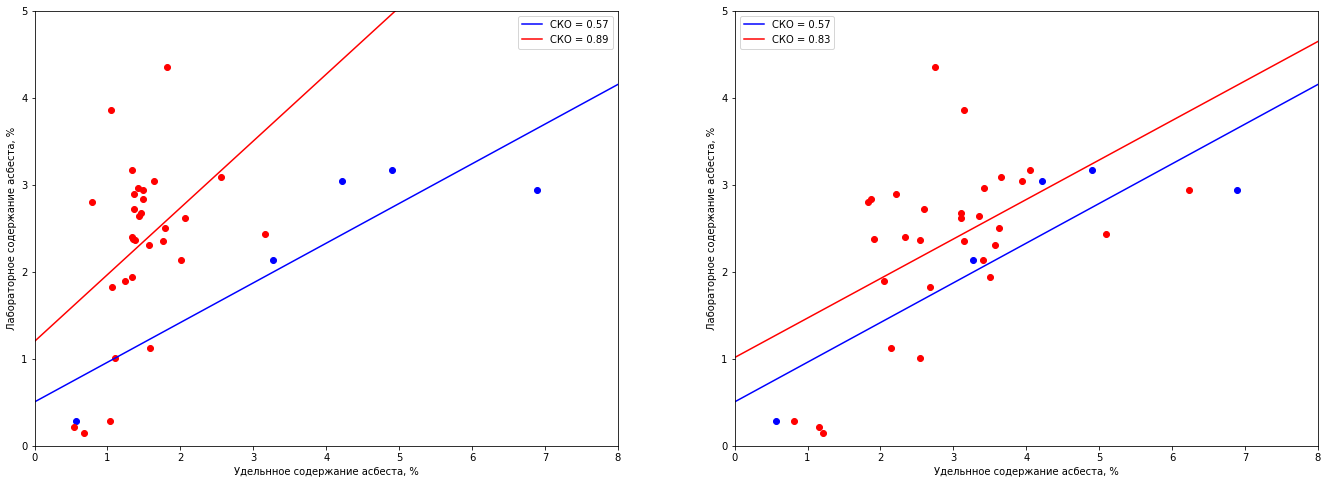

In [50]:
mean_manual_results = {'probes' : [], 'preds' : [], 'trues' : []}
mean_net_results_1 = {'probes' : [], 'preds' : [], 'trues' : []}
mean_net_results_2 = {'probes' : [], 'preds' : [], 'trues' : []}

for prob in range(1,31):
    index = np.array(manual_results['probes']) == prob
    if any(index):
        mean_manual_results['probes'].append(prob)
        mean_manual_results['preds'].append(np.mean(np.array(manual_results['preds'])[index]))
        mean_manual_results['trues'].append(np.mean(np.array(manual_results['trues'])[index]))
        
    index = np.array(net_results_1['probes']) == prob
    if any(index):
        mean_net_results_1['probes'].append(prob)
        mean_net_results_1['preds'].append(np.mean(np.array(net_results_1['preds'])[index]))
        mean_net_results_1['trues'].append(np.mean(np.array(net_results_1['trues'])[index]))
        
    index = np.array(net_results_2['probes']) == prob
    if any(index):
        mean_net_results_2['probes'].append(prob)
        mean_net_results_2['preds'].append(np.mean(np.array(net_results_2['preds'])[index]))
        mean_net_results_2['trues'].append(np.mean(np.array(net_results_2['trues'])[index]))
        
p_manual = np.polyfit(mean_manual_results['preds'], mean_manual_results['trues'], 1)
reg_manual = np.polyval(p_manual, [0, 10])

p_net_1 = np.polyfit(mean_net_results_1['preds'], mean_net_results_1['trues'], 1)
reg_net_1 = np.polyval(p_net_1, [0, 10])

p_net_2 = np.polyfit(mean_net_results_2['preds'], mean_net_results_2['trues'], 1)
reg_net_2 = np.polyval(p_net_2, [0, 10])

plt.figure(figsize=(23,8))
plt.subplot(121)
plt.scatter(mean_manual_results['preds'], mean_manual_results['trues'], c='b')
sigma_manual = np.sqrt(np.sum((np.array(mean_manual_results['trues']) - np.polyval(p_manual, mean_manual_results['preds'])) ** 2) / (len(mean_manual_results['trues']) - 1))
plt.plot([0, 10], reg_manual, 'b', label='СКО = ' + '{:.2f}'.format(sigma_manual))

sigma_net_1 = np.sqrt(np.sum((np.array(mean_net_results_1['trues']) - np.polyval(p_net_1, mean_net_results_1['preds'])) ** 2) / (len(mean_net_results_1['trues']) - 1))
plt.scatter(mean_net_results_1['preds'], mean_net_results_1['trues'], c='r')
plt.plot([0, 10], reg_net_1, 'r', label='СКО = ' + '{:.2f}'.format(sigma_net_1))

plt.legend()
plt.xlim(0, 8)
plt.ylim(0, 5)
plt.xlabel('Удельнное содержание асбеста, %')
plt.ylabel('Лабораторное содержание асбеста, %')

plt.subplot(122)
plt.scatter(mean_manual_results['preds'], mean_manual_results['trues'], c='b')
sigma_manual = np.sqrt(np.sum((np.array(mean_manual_results['trues']) - np.polyval(p_manual, mean_manual_results['preds'])) ** 2) / (len(mean_manual_results['trues']) - 1))
plt.plot([0, 10], reg_manual, 'b', label='СКО = ' + '{:.2f}'.format(sigma_manual))

plt.scatter(mean_net_results_2['preds'], mean_net_results_2['trues'], c='r')
sigma_net_2 = np.sqrt(np.sum((np.array(mean_net_results_2['trues']) - np.polyval(p_net_2, mean_net_results_2['preds'])) ** 2) / (len(mean_net_results_2['trues']) - 1))
plt.plot([0, 10], reg_net_2, 'r', label='СКО = ' + '{:.2f}'.format(sigma_net_2))

plt.legend()
plt.xlim(0, 8)
plt.ylim(0, 5)
plt.xlabel('Удельнное содержание асбеста, %')
plt.ylabel('Лабораторное содержание асбеста, %')

In [57]:
print('САО Ручная разметка:')
print(np.mean(np.abs(np.array(mean_manual_results['trues']) - np.polyval(p_manual, mean_manual_results['preds']))))
print('САО модель №1:')
print(np.mean(np.abs(np.array(mean_net_results_1['trues']) - np.polyval(p_net_1, mean_net_results_1['preds']))))
print('САО модель №2:')
print(np.mean(np.abs(np.array(mean_net_results_2['trues']) - np.polyval(p_net_2, mean_net_results_2['preds']))))

САО Ручная разметка:
0.4734720729306547
САО модель №1:
0.6763816273952632
САО модель №2:
0.6511862036794895


In [55]:
p_net_1

array([0.76793058, 1.20074464])

In [56]:
p_net_2

array([0.45433483, 1.0144409 ])

In [37]:
print('Ручная разметка без градуировки:')
print(np.mean(np.abs(np.array(manual_results['preds']) - np.array(manual_results['trues']))))
print('Модель №1 без градуировки:')
print(np.mean(np.abs(np.array(net_results_1['preds']) - np.array(net_results_1['trues']))))
print('Модель №2 без градуировки:')
print(np.mean(np.abs(np.array(net_results_2['preds']) - np.array(net_results_2['trues']))))

print('Ручная разметка с градуировкой:')
print(np.mean(np.abs(np.array(manual_results['trues']) - np.polyval(p_manual, manual_results['preds']))))
print('Модель №1 с градуировкой:')
print(np.mean(np.abs(np.array(net_results_1['trues']) - np.polyval(p_net_1, net_results_1['preds']))))
print('Модель №2 с градуировкой:')
print(np.mean(np.abs(np.array(net_results_2['trues']) - np.polyval(p_net_2, net_results_2['preds']))))
# print(np.mean(np.abs(np.array(net_results_2['preds']) - np.array(net_results_2['trues']))))

Ручная разметка без градуировки:
1.6537982844912311
Модель №1 без градуировки:
1.0655624019583176
Модель №2 без градуировки:
0.9653390373409195
Ручная разметка с градуировкой:
0.47697567037190597
Модель №1 с градуировкой:
0.7111882628454252
Модель №2 с градуировкой:
0.669798352672797


In [51]:
print('Дисперсия:')
print(np.sqrt(np.sum((np.array(manual_results['trues']) - np.polyval(p_manual, manual_results['preds'])) ** 2) / (len(manual_results['trues']) - 1)))
print('Модель №1 с градуировкой:')
print(np.sqrt(np.sum((np.array(net_results_1['trues']) - np.polyval(p_net_1, net_results_1['preds'])) ** 2) / (len(net_results_1['trues']) - 1)))
print('Модель №2 с градуировкой:')
print(np.sqrt(np.sum((np.array(net_results_2['trues']) - np.polyval(p_net_2, net_results_2['preds'])) ** 2) / (len(net_results_2['trues']) - 1)))

Дисперсия:
0.5954898633784347
Модель №1 с градуировкой:
0.9174015440184028
Модель №2 с градуировкой:
0.8431707100192005


In [7]:
data = {}
data['проба'] = probes
data['лаб'] = trues
data['модель №1'] = predicts_1
data['модель №2'] = predicts_2
df = pd.DataFrame(data)
gb = df.groupby('проба')
gb = gb.agg({'лаб' : np.mean,
             'модель №1' : [np.min, np.mean, np.max],
             'модель №2' : [np.min, np.mean, np.max],
       })
gb

лаб модель №1                     модель №2                    
       mean      amin      mean      amax      amin      mean      amax
проба                                                                  
1      1.94  0.989110  1.222449  1.469105  3.085399  3.191636  3.325753
2      1.89  0.771957  1.172942  1.930492  1.794447  1.884175  1.984830
3      2.89  0.813560  1.229071  1.935633  1.912596  2.021066  2.192365
4      2.62  1.884287  1.954951  2.065451  2.704127  2.950970  3.345038
5      1.12  0.996557  1.459912  2.014516  1.300102  1.943486  2.332190
6      3.86  0.679046  0.948936  1.336000  2.118779  2.998956  3.585875
7      2.72  1.133100  1.310449  1.527855  2.253465  2.476799  2.635318
8      2.84  1.093570  1.413063  1.924917  1.255040  1.706277  2.255823
9      2.37  0.878154  1.342925  2.137128  1.778326  2.412574  3.150020
10     0.29  0.856156  0.990863  1.072640  0.633376  0.708129  0.799167
11     2.14  1.069905  1.934565  2.795987  2.468474  3.265142  3.780242
12     3.17  0.985678  1.296940  1.580912  3.185297  3.806259  4.168461
13     3.04  1.425542  1.591739  1.705626  3.435361  3.705405  3.901356
14     2.94  1.178442  1.372799  1.606871  5.028650  6.043292  6.576751
15     2.40  0.987287  1.256462  1.566164  1.904346  2.222619  2.599664
16     2.35  1.278095  1.510593  1.837578  2.276444  2.823050  3.724604
17     3.09  2.111494  2.352345  2.741296  2.718848  2.984346  3.441864
18     2.80  0.655933  0.672326  0.685884  1.519991  1.672233  1.928648
19     2.38  0.981797  1.242158  1.521600  1.312333  1.735115  2.068622
20     0.22  0.309286  0.510103  0.702101  0.796977  1.089708  1.641390
21     1.01  0.793560  1.010446  1.238513  2.222082  2.405945  2.675213
22     4.36  1.349891  1.703849  2.084518  2.142616  2.525778  2.991989
23     2.64  0.982305  1.228047  1.402750  3.059719  3.135426  3.250400
24     1.83  0.723626  0.932994  1.085347  2.231806  2.508172  2.720182
25     2.50  1.548594  1.650562  1.767386  3.151558  3.411213  3.737190
26     2.44  2.628158  3.041942  3.457272  4.706500  4.857064  4.993131
27     2.31  1.222339  1.456336  1.718562  2.819841  3.334884  3.670238
28     2.68  1.136465  1.348144  1.675527  2.523928  2.853092  3.079926
29     2.96  1.077516  1.296134  1.628924  2.607951  3.166406  3.541546
30     0.15  0.452882  0.575911  0.669883  1.049191  1.107773  1.194923

In [8]:
gb.to_csv('graphics/models_table.csv')

In [18]:
from scipy import stats
import seaborn as sns
gb = pd.read_csv('graphics/models_table.csv', skiprows=3, names=['проба', 
                                                       'лаб', 
                                                       '1 min', 
                                                       '1 mean', 
                                                       '1 max', 
                                                       '2 min', 
                                                       '2 mean', 
                                                       '2 max'])
gb

,проба,лаб,1 min,1 mean,1 max,2 min,2 mean,2 max
0,1,1.94,0.989110,1.222449,1.469105,3.085399,3.191636,3.325753
1,2,1.89,0.771957,1.172942,1.930492,1.794447,1.884175,1.984830
2,3,2.89,0.813560,1.229071,1.935633,1.912596,2.021066,2.192365
3,4,2.62,1.884287,1.954951,2.065451,2.704127,2.950970,3.345038
4,5,1.12,0.996557,1.459912,2.014516,1.300102,1.943486,2.332190
5,6,3.86,0.679046,0.948936,1.336000,2.118779,2.998956,3.585875
6,7,2.72,1.133100,1.310449,1.527855,2.253465,2.476799,2.635318
7,8,2.84,1.093570,1.413063,1.924917,1.255040,1.706277,2.255823
8,9,2.37,0.878154,1.342925,2.137128,1.778326,2.412574,3.150020
9,10,0.29,0.856156,0.990863,1.072640,0.633376,0.708129,0.799167


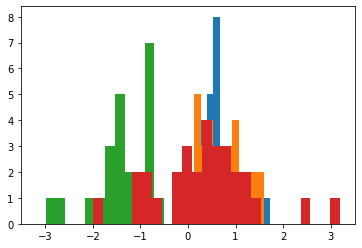

In [159]:
x_1 = gb[('1 max')] - gb[('1 min')]
x_2 = gb[('2 max')] - gb[('2 min')]
# kde = stats.gaussian_kde(x)
# xx = np.linspace(0, 2, 1000)
n_1, bins_1, _ = plt.hist(x_1, bins=15, range=[0,2]);
n_2, bins_2, _ = plt.hist(x_2, bins=15, range=[0,2]);
# sns.distplot(x, hist=True, bins =10,  norm_hist=False)
bins_1 = [(bins_1[i] + bins_1[i+1]) / 2 for i in range(len(bins_1)-1)]
bins_2 = [(bins_2[i] + bins_2[i+1]) / 2 for i in range(len(bins_2)-1)]

x_1_err = gb[('1 mean')] - gb[('лаб')]
x_2_err = gb[('2 mean')] - gb[('лаб')]
# kde = stats.gaussian_kde(x)
# xx = np.linspace(0, 2, 1000)
n_1_e, bins_1_e, _ = plt.hist(x_1_err, bins=25,range=[-3.2,2]);
n_2_e, bins_2_e, _ = plt.hist(x_2_err, bins=25,range=[-2,3.2]);
# sns.distplot(x, hist=True, bins =10,  norm_hist=False)
bins_1_e = [(bins_1_e[i] + bins_1_e[i+1]) / 2 for i in range(len(bins_1_e)-1)]
bins_2_e = [(bins_2_e[i] + bins_2_e[i+1]) / 2 for i in range(len(bins_2_e)-1)]

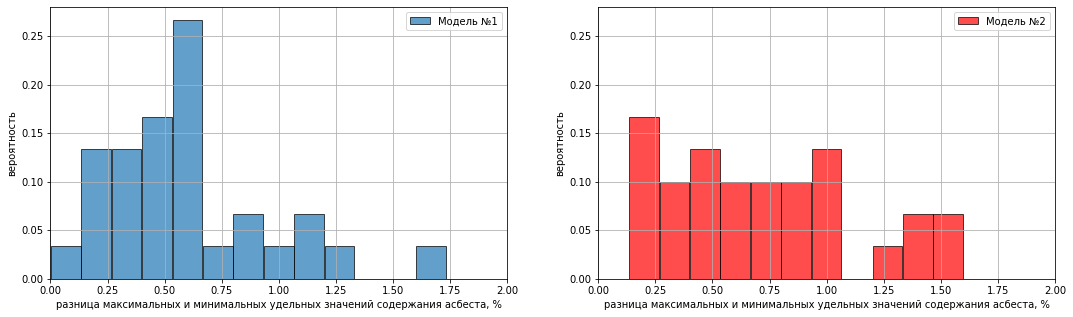

In [177]:
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.bar(bins_1, n_1/30, width=0.13, alpha=0.7, edgecolor='k', label='Модель №1')#, where='mid')
plt.grid('on')
plt.xlim(0, 2)
plt.ylim(0, 0.28)
# plt.title('Распределение разницы максимальных и минимальных значений')
plt.xlabel('разница максимальных и минимальных удельных значений содержания асбеста, %')
plt.ylabel('вероятность')
plt.legend()

plt.subplot(122)
plt.bar(bins_2, n_2/30, width=0.13, alpha=0.7, color='r', edgecolor='k', label='Модель №2')#, where='mid')
plt.grid('on')
plt.xlim(0, 2)
plt.ylim(0, 0.28)
# plt.title('Распределение разницы максимальных и минимальных значений для модели №2')
# plt.xlabel('разница максимальных и минимальных удельных значений содержания асбеста, %')
plt.ylabel('вероятность')
plt.xlabel('разница максимальных и минимальных удельных значений содержания асбеста, %')
plt.legend()
# kde = stats.gaussian_kde(x)
# xx = np.linspace(0, 2, 1000)
# plt.plot(xx, kde(xx))
plt.savefig('graphics/dist_1.png')

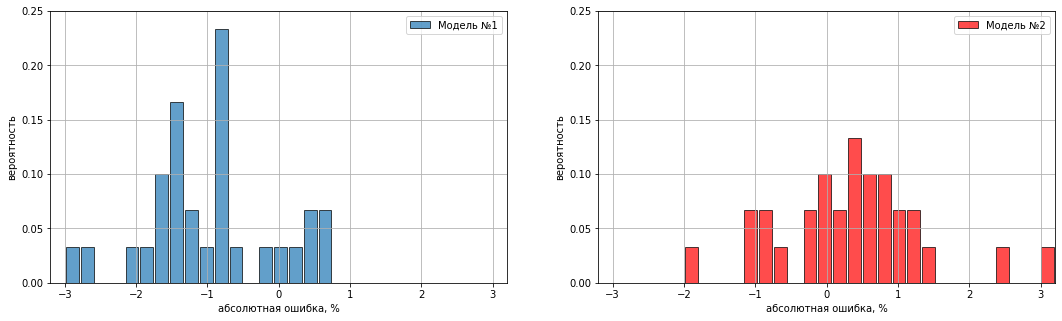

In [179]:
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.bar(bins_1_e, n_1_e/30, width=0.18, alpha=0.7, edgecolor='k', label='Модель №1')#, where='mid')
plt.grid('on')
plt.xlim(-3.2, 3.2)
plt.ylim(0, 0.25)
plt.ylabel('вероятность')
# plt.title('Распределение абсолютных ошибок')
plt.xlabel('aбсолютная ошибка, %')
plt.legend()

plt.subplot(122)
plt.bar(bins_2_e, n_2_e/30, width=0.18, alpha=0.7, color='r', edgecolor='k', label='Модель №2')#, where='mid')
plt.grid('on')
plt.xlim(-3.2, 3.2)
plt.ylim(0, 0.25)
plt.ylabel('вероятность')
# plt.title('Распределение разницы максимальных и минимальных значений для модели №2')
plt.xlabel('aбсолютная ошибка, %')
plt.legend()
# kde = stats.gaussian_kde(x)
# xx = np.linspace(0, 2, 1000)
# plt.plot(xx, kde(xx))
plt.savefig('graphics/dist_2.png')

KeyError: ('модель №1', 'amax')

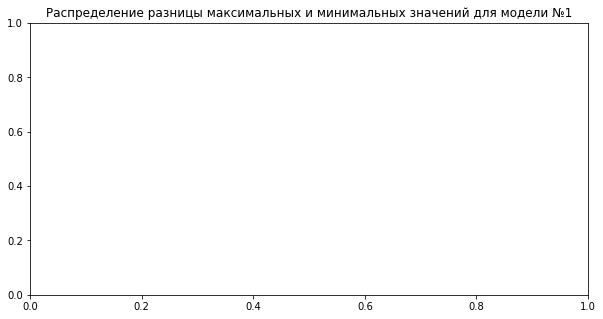

In [138]:
plt.figure(figsize=(10,5))
plt.title('Распределение разницы максимальных и минимальных значений для модели №1')
plt.hist(gb[('модель №1', 'amax')] - gb[('модель №1', 'amin')], bins=20)
plt.xlabel('удельное содержание асбеста, %')

Text(0.5, 0, 'удельное содержание асбеста, %')

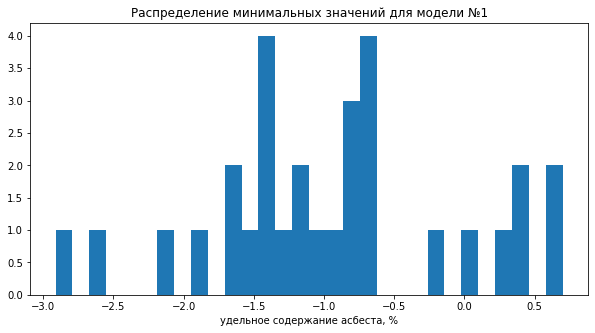

In [18]:
plt.figure(figsize=(10,5))
plt.title('Распределение минимальных значений для модели №1')
plt.hist(gb[('модель №1', 'mean')] - gb[('лаб', 'mean')], bins=30)
plt.xlabel('ошибка удельное содержание асбеста, %')

Text(0.5, 0, 'удельное содержание асбеста, %')

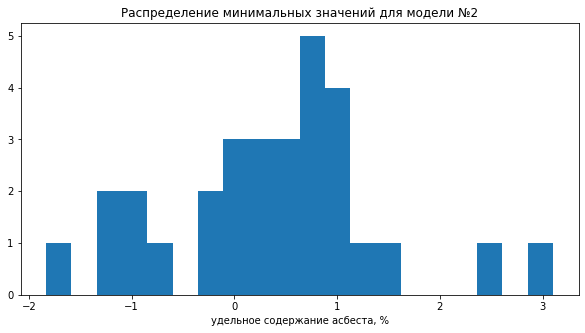

In [21]:
plt.figure(figsize=(10,5))
plt.title('Распределение минимальных значений для модели №2')
plt.hist(gb[('модель №2', 'mean')] - gb[('лаб', 'mean')], bins=20)
plt.xlabel('удельное содержание асбеста, %')